In [40]:
class CONSTS:
    fontsize = 16

from conex.helpers.filters import DoGFilter, GaborFilter
from conex.helpers.transforms import Conv2dFilter
import torch
import numpy as np
def filtered(imarray, dog=True, gab=True, size=5, 
             dog_params={"sigma_1": 10.0, "sigma_2": 16.0}, 
             gab_params={"labda": 1.1, "theta": np.pi/2, "sigma": 0.5, "gamma": 0.5}):
    dogFilter = DoGFilter(size=size, **dog_params)
    gabFilter = GaborFilter(size=size, **gab_params)
    filters = []
    if dog:
        filters.append(dogFilter.unsqueeze(0))
    if gab:
        filters.append(gabFilter.unsqueeze(0))
    
    weights = torch.concat(filters).reshape((1, -1, size, size))
    convfil = Conv2dFilter(filters=weights)
    

    imarray2 = torch.concat([imarray, imarray]) if len(filters) == 2 else imarray
    # print(f"im: {imarray2.shape}, dtype: {imarray2.dtype}")

    return convfil(imarray2).squeeze()


rows: 2, cols: 3


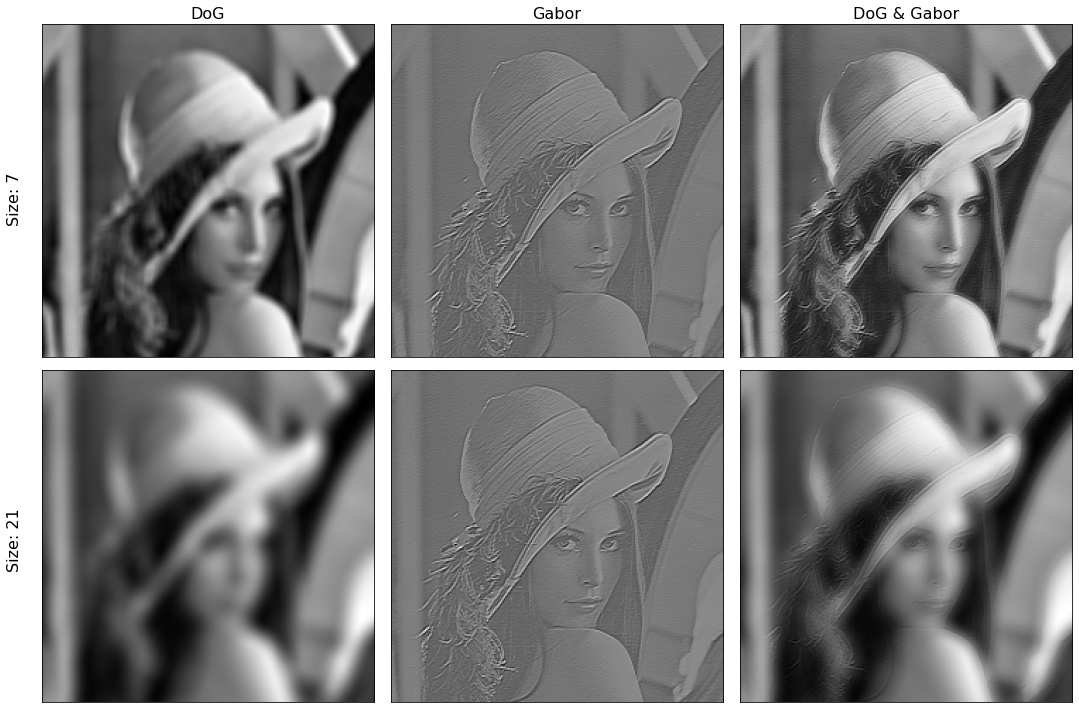

In [44]:
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

image = Image.open(f"images/lena1.tif")
imarray = torch.tensor(np.array(image)).unsqueeze(0).type(torch.float32)

conv_params = [
    {"dog": True, "gab": False, "size": 7},
    {"dog": False, "gab": True, "size": 7},
    {"dog": True, "gab": True, "size": 7},
    {"dog": True, "gab": False, "size": 21},
    {"dog": False, "gab": True, "size": 21},
    {"dog": True, "gab": True, "size": 21},
    
    ]
conveds = [filtered(imarray=imarray, **param) for param in conv_params]
rows, cols = len(conveds) // 3, 3
print(f"rows: {rows}, cols: {cols}")
fig, ax = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows), sharex=True, sharey=True)

# removing ticks
for a in ax:
    try:
        a.set_xticks([])
        a.set_yticks([])
    except AttributeError:
        for b in a:
            b.set_xticks([])
            b.set_yticks([])

for i in range(len(conveds)):
    if rows == 1:
        ax[i].imshow(conveds[i], cmap="gray")
    else:
        ax[i // 3, i % 3].imshow(conveds[i], cmap="gray")
    
ax[0, 0].set_title("DoG", fontsize=CONSTS.fontsize)
ax[0, 1].set_title("Gabor", fontsize=CONSTS.fontsize)
ax[0, 2].set_title("DoG & Gabor", fontsize=CONSTS.fontsize)
ax[0, 0].text(-25, 140, "Size: 7", rotation="vertical", fontsize=CONSTS.fontsize)
ax[1, 0].text(-25, 140, "Size: 21", rotation="vertical", fontsize=CONSTS.fontsize)
fig.tight_layout()
plt.show()




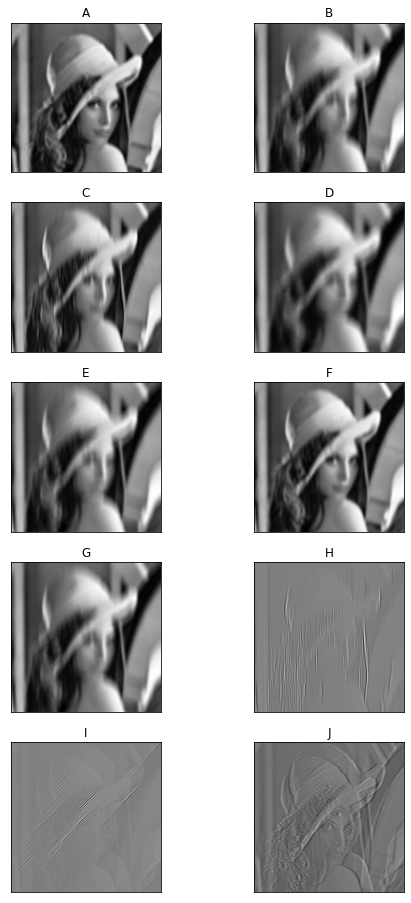

In [12]:
import matplotlib.pyplot as plt
import torch
from PIL import Image
import numpy as np
from conex.helpers.filters import DoGFilter, GaborFilter
from conex.helpers.transforms import Conv2dFilter


image = Image.open(f"images/lena1.tif")
imarray = torch.tensor(np.array(image)).unsqueeze(0).type(torch.float32)
fig, ax = plt.subplots(5, 2, figsize=(8, 16), sharex=True, sharey=True)

# removing ticks
for a in ax:
    for b in a:
        b.set_xticks([])
        b.set_yticks([])

def bigbig(x:torch.Tensor, mul:int):
    a, b = x.shape[0] * mul, x.shape[1]*mul
    y = torch.zeros(a, b)
    for i in range(a):
        for j in range(b):
            y[i, j] = x[i//mul, j//mul]
    return y

dogp = {"sigma_1": 10.0, "sigma_2": 16.0}
gabp = {"labda": 1.1, 'theta': 90.0, 'sigma': 1.5, 'gamma': 0.1}
# ax[0, 1].imshow(Conv2dFilter(DoGFilter(size=21, sigma_1=10.0, sigma_2=16.0).reshape(1, 1, 21, 21))(imarray).squeeze(), cmap="gray")
# ax[0, 0].imshow(Conv2dFilter(DoGFilter(size= 7, sigma_1=10.0, sigma_2=16.0).reshape(1, 1,  7,  7))(imarray).squeeze(), cmap="gray")
# ax[1, 0].imshow(Conv2dFilter(DoGFilter(size=21, sigma_1=5.00, sigma_2=16.0).reshape(1, 1, 21, 21))(imarray).squeeze(), cmap="gray")
# ax[1, 1].imshow(Conv2dFilter(DoGFilter(size=21, sigma_1=15.0, sigma_2=16.0).reshape(1, 1, 21, 21))(imarray).squeeze(), cmap="gray")
# ax[2, 0].imshow(Conv2dFilter(DoGFilter(size=21, sigma_1=16.0, sigma_2=10.0).reshape(1, 1, 21, 21))(imarray).squeeze(), cmap="gray")
# ax[2, 1].imshow(Conv2dFilter(DoGFilter(size=21, sigma_1=16.0, sigma_2=5.00).reshape(1, 1, 21, 21))(imarray).squeeze(), cmap="gray")

ax[0, 0].imshow(Conv2dFilter(GaborFilter(size=7 , labda=1.0, theta=np.pi/2, sigma=1.5, gamma=0.1 ).reshape(1, 1,  7,  7))(imarray).squeeze(), cmap="gray")
ax[0, 1].imshow(Conv2dFilter(GaborFilter(size=21, labda=1.0, theta=np.pi/2, sigma=1.5, gamma=0.1 ).reshape(1, 1, 21, 21))(imarray).squeeze(), cmap="gray")
ax[1, 0].imshow(Conv2dFilter(GaborFilter(size=21, labda=1.0, theta=np.pi/2, sigma=0.5, gamma=0.1 ).reshape(1, 1, 21, 21))(imarray).squeeze(), cmap="gray")
ax[1, 1].imshow(Conv2dFilter(GaborFilter(size=21, labda=1.0, theta=np.pi/2, sigma=2.5, gamma=0.1 ).reshape(1, 1, 21, 21))(imarray).squeeze(), cmap="gray")
ax[2, 0].imshow(Conv2dFilter(GaborFilter(size=21, labda=1.0, theta=np.pi/2, sigma=1.5, gamma=0.05).reshape(1, 1, 21, 21))(imarray).squeeze(), cmap="gray")
ax[2, 1].imshow(Conv2dFilter(GaborFilter(size=21, labda=1.0, theta=np.pi/2, sigma=1.5, gamma=0.5 ).reshape(1, 1, 21, 21))(imarray).squeeze(), cmap="gray")
ax[3, 0].imshow(Conv2dFilter(GaborFilter(size=21, labda=0.5, theta=np.pi/2, sigma=1.5, gamma=0.1 ).reshape(1, 1, 21, 21))(imarray).squeeze(), cmap="gray")
ax[3, 1].imshow(Conv2dFilter(GaborFilter(size=21, labda=1.5, theta=np.pi/2, sigma=1.5, gamma=0.1 ).reshape(1, 1, 21, 21))(imarray).squeeze(), cmap="gray")
ax[4, 0].imshow(Conv2dFilter(GaborFilter(size=21, labda=1.0, theta=np.pi/4, sigma=1.5, gamma=0.1 ).reshape(1, 1, 21, 21))(imarray).squeeze(), cmap="gray")
ax[4, 1].imshow(Conv2dFilter(GaborFilter(size=21, labda=1.0, theta=np.pi/3, sigma=1.5, gamma=0.1 ).reshape(1, 1, 21, 21))(imarray).squeeze(), cmap="gray")



for i in range(10):
    ax[i // 2, i % 2].set_title(chr(65 + i))